# Prima prova, primo allenamento

Obbiettivi:


*   Transfer learning
*   data augmentation
*   Split del dataset
*   Allenamento della rete con early stopping
*   Confusion matrix sul validation dataset

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import cv2

import os
import time 
from PIL import Image

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
#from keras.layers.normalization import BatchNormalization
from keras.models import Sequential

!pip install alexnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)


# Download and import visualkeras library
!pip install visualkeras
import visualkeras

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

2.9.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 15.3 MB/s 


# Scelta modello e Fine Tuning

Let's import the feature extraction network of the VGG16 model, adding the new classifier layers with an output layer of 8 neurons (as many as the number of classes in the dataset)

In [ ]:
# example of tending the vgg16 model
from keras.applications.vgg16 import VGG16

inputshape = [96, 96, 3]
vgg16 = VGG16(include_top=False, input_shape=inputshape)
for layer in vgg16.layers:
	layer.trainable = True

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
def effnet():
  effnet = tf.keras.applications.EfficientNetB0(
      include_top=True,
      weights="imagenet",
      #input_shape=inputshape,
      classes=1000,
      classifier_activation="softmax"
  )



In [ ]:
def create_model(input_shape, convnet):
  # mark loaded layers as not trainable

  dropout_rate = 0.2
    
    # Da provare: flatten, dropout, dense (relu), dropout, dense (softmax)

    # Build the model
  input_layer = convnet.layers[0].input
  flat1 = Flatten()(convnet.layers[-1].output)
  flat1 = tfkl.Dropout(dropout_rate, seed=seed)(flat1)
  hidden_layer1 = tfkl.Dense(units=1024, activation='relu', name='Hidden1', 
                                kernel_initializer=tfk.initializers.HeUniform(seed=seed))(flat1)
  hidden_layer1 = tfkl.Dropout(dropout_rate, seed=seed)(hidden_layer1)
  output = tfkl.Dense(units=8, activation='softmax', name='Dropout', 
                                kernel_initializer=tfk.initializers.HeUniform(seed=seed))(hidden_layer1)
    # Connect input and output through the Model class
  model = tfk.Model(inputs=input_layer, outputs=output, name='model')

    # Compile the model
  learning_rate = 1e-5
  opt = tfk.optimizers.Adam(learning_rate)
  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=opt, metrics='accuracy')

    # Return the model
  return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

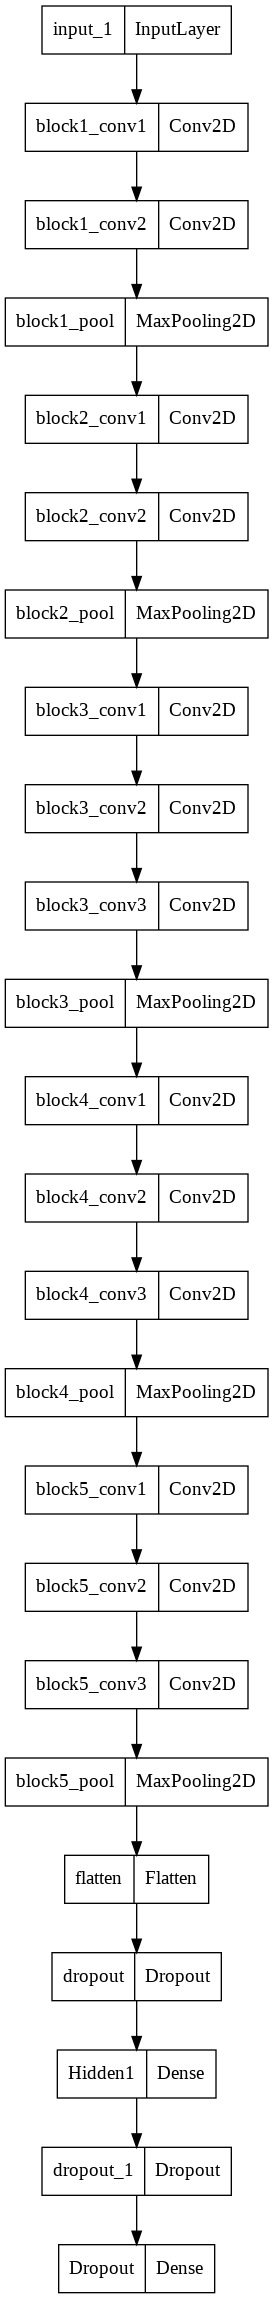

In [ ]:
# summarize

model = create_model(input_shape = inputshape, convnet = vgg16)
model.summary()

tfk.utils.plot_model(model)

#  Splitting the dataset

Before splitting the dataset let's analyze it

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive

Mounted at /gdrive
/gdrive/My Drive


In [ ]:
data_dir="training_data_final"
batch_size = 16
img_height = 96
img_width = 96

In [ ]:
def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 70
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

def change_color(image):
    image = np.array(image)
    hsv_image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    return hsv_image

def preprocessing(image):
    CP1 = 0.3
    CP2 = 0.6
    n = random.random()
    if n<=CP1: 
        return change_color(image)
    elif n>CP1 and n<=CP2:
        return add_noise(image)
    return image

In [ ]:
training_dir = data_dir
from keras_preprocessing.image import ImageDataGenerator
data_gen = ImageDataGenerator(rescale=1/255, validation_split=0.2)
aug_train_data_gen = ImageDataGenerator(rotation_range=30, 
                                        height_shift_range=50, 
                                        width_shift_range=50, 
                                        zoom_range=0.3, 
                                        horizontal_flip=True, 
                                        vertical_flip=True,  
                                        fill_mode='reflect',
                                        #preprocessing_function=preprocessing,
                                        rescale=1/255, 
                                        validation_split=0.2)
train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=64,
                                               shuffle=True,
                                               seed=seed,
                                               subset="training")

valid_gen = data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               #classes=labels, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=1,
                                               shuffle=True,
                                               seed=seed,
                                               subset="validation")



Found 2836 images belonging to 8 classes.
Found 706 images belonging to 8 classes.


In [ ]:
countclass=[0,0,0,0,0,0,0,0]
for i in train_gen.classes:
  countclass[i] = countclass[i] + 1;

print(countclass)

tot = len(train_gen.classes)

print(tot)

weights = np.zeros(8, dtype=float)
for x in range(8):
  weights[x] = tot/countclass[x]

weights = weights.astype(int)

print(weights)

[149, 426, 412, 409, 425, 178, 430, 407]
2836
[19  6  6  6  6 15  6  6]


In [ ]:
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_W')

patience = 150
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_mse', mode='min', patience=patience, restore_best_weights=True)

# Train the model
tl_history = model.fit(
    train_gen,
    epochs = 200,
    validation_data = valid_gen,
    class_weight = {0:19,  1:6,  2:6,  3:6,  4:6, 5:15,  6:6,  7:6},
    callbacks=callbacks
).history



Epoch 1/200
45/45 [==============================] - ETA: 0s - loss: 3.2482 - accuracy: 0.8283

45/45 [==============================] - 24s 543ms/step - loss: 3.2482 - accuracy: 0.8283 - val_loss: 0.4702 - val_accuracy: 0.8300
Epoch 2/200
45/45 [==============================] - ETA: 0s - loss: 3.3853 - accuracy: 0.8336

45/45 [==============================] - 24s 533ms/step - loss: 3.3853 - accuracy: 0.8336 - val_loss: 0.4947 - val_accuracy: 0.8258
Epoch 3/200
45/45 [==============================] - ETA: 0s - loss: 3.2811 - accuracy: 0.8360

45/45 [==============================] - 24s 544ms/step - loss: 3.2811 - accuracy: 0.8360 - val_loss: 0.5446 - val_accuracy: 0.8102
Epoch 4/200
45/45 [==============================] - ETA: 0s - loss: 3.0814 - accuracy: 0.8452

45/45 [==============================] - 24s 532ms/step - loss: 3.0814 - accuracy: 0.8452 - val_loss: 0.5428 - val_accuracy: 0.8144
Epoch 5/200
45/45 [==============================] - ETA: 0s - loss: 3.1769 - accuracy: 0.8403

45/45 [==============================] - 24s 526ms/step - loss: 3.1769 - accuracy: 0.8403 - val_loss: 0.5260 - val_accuracy: 0.8159
Epoch 6/200
45/45 [==============================] - ETA: 0s - loss: 3.0905 - accuracy: 0.8413

45/45 [==============================] - 26s 576ms/step - loss: 3.0905 - accuracy: 0.8413 - val_loss: 0.4622 - val_accuracy: 0.8414
Epoch 7/200
45/45 [==============================] - ETA: 0s - loss: 2.9654 - accuracy: 0.8477

45/45 [==============================] - 25s 554ms/step - loss: 2.9654 - accuracy: 0.8477 - val_loss: 0.4690 - val_accuracy: 0.8456
Epoch 8/200
45/45 [==============================] - ETA: 0s - loss: 2.8652 - accuracy: 0.8561

45/45 [==============================] - 24s 535ms/step - loss: 2.8652 - accuracy: 0.8561 - val_loss: 0.6711 - val_accuracy: 0.7720
Epoch 9/200
45/45 [==============================] - ETA: 0s - loss: 3.2556 - accuracy: 0.8353

45/45 [==============================] - 26s 586ms/step - loss: 3.2556 - accuracy: 0.8353 - val_loss: 0.4564 - val_accuracy: 0.8470


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
#Confution Matrix and Classification Report
Y_pred = tl_history.predict(valid_gen)
y_pred = np.argmax(Y_pred, axis=1)

AttributeError: ignored

In [ ]:
print('Confusion Matrix')
print(confusion_matrix(valid_gen.classes, y_pred))
print('Classification Report')
target_names = ['1', '2', '3', '4', '5', '6', '7', '8']
print(classification_report(valid_gen.classes, y_pred, target_names=target_names))

Confusion Matrix
[[ 6  5  5  5  3  3  6  4]
 [ 8 15 15 17 19  5 13 14]
 [ 6 19 19 13 16  3 14 13]
 [ 6  8 15 14 17  7 18 17]
 [ 6 19 16 16 18  5 14 12]
 [ 2  6  2  5  8  2 11  8]
 [ 7 19 12 22 17  5 14 11]
 [ 8 13 18 15 15  4 16 12]]
Classification Report
              precision    recall  f1-score   support

           1       0.12      0.16      0.14        37
           2       0.14      0.14      0.14       106
           3       0.19      0.18      0.19       103
           4       0.13      0.14      0.13       102
           5       0.16      0.17      0.16       106
           6       0.06      0.05      0.05        44
           7       0.13      0.13      0.13       107
           8       0.13      0.12      0.12       101

    accuracy                           0.14       706
   macro avg       0.13      0.14      0.13       706
weighted avg       0.14      0.14      0.14       706

